# Анализ убытков приложения ProcrastinatePRO+

Несколько прошлых месяцев наш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нам нужно разобраться в причинах этой ситуации.

У нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. 

***Описание данных***

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

- User Id — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Session start — дата и время начала сессии
- Session End — дата и время окончания сессии
- Channel — идентификатор рекламного источника, из которого пришел пользователь
- Region - страна пользователя

Таблица orders_log_short (информация о заказах):

- User Id — уникальный id пользователя, который сделал заказ
- Event Dt — дата и время покупки
- Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

- Channel — идентификатор рекламного источника
- Dt — дата
- Costs — затраты на этот рекламный источник в этот день

# Шаг 1. Загрузка данных и подготовка к анализу

Открываем файлы.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('C:\\Users\\Вадим\\Desktop\\практикум\\проекты на github\\Портфолио\\marketing_project\\visits_info_short.csv')
orders = pd.read_csv('C:\\Users\\Вадим\\Desktop\\практикум\\проекты на github\\Портфолио\\marketing_project\\orders_info_short.csv')
costs = pd.read_csv('C:\\Users\\Вадим\\Desktop\\практикум\\проекты на github\\Портфолио\\marketing_project\\costs_info_short.csv')

Переименуем и опустим названия столбцов в нижний регистр.

In [3]:
for data in [visits,orders,costs]:
    data.columns = [x.lower().replace(' ', '_') for x in data.columns]

Поменяем тип данных в столбцах с датами.

In [4]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [5]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [6]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Снова посмотрим на готовые таблицы.

In [7]:
display(visits.head())
print('-'*60)
visits.info()
print('='*60)

display(orders.head())
print('-'*60)
orders.info()
print('='*60)

display(costs.head())
print('-'*60)
costs.info()
print('='*60)

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Ищем дубликаты.

In [8]:
visits[['user_id','session_start']].duplicated().value_counts()

False    309901
dtype: int64

In [9]:
orders['event_dt'].duplicated().value_counts()

False    40163
True        49
Name: event_dt, dtype: int64

In [10]:
costs[['dt','channel']].duplicated().value_counts()

False    1800
dtype: int64

Так как дата заказа вполне может совпадать у нескольких user_id оставляем всё как есть. Дубликаты не найдены. 

In [11]:
for data in [visits,orders,costs]:
    for column in data.columns:
        print(data[column].isna().sum(), column)

0 user_id
0 region
0 device
0 channel
0 session_start
0 session_end
0 user_id
0 event_dt
0 revenue
0 dt
0 channel
0 costs


Пропусков в данных не обнаружено.

# Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии

### GET_PROFILES()

In [12]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### GET_RETENTION()

In [13]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### GET_CONVERSION()

In [14]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### GET_LTV()

In [15]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### PLOT_RETENTION

In [16]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### PLOT_CONVERSION

In [17]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### PLOT_LTV_ROI

In [18]:
# функция для сглаживания датафрейма
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Шаг 3. Исследовательский анализ данных

Получаем профили пользователей

In [19]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Напишем функцию для создания таблицы привлеченных пользователей.

In [20]:
def table_conv(column):
    
    total_users = profiles.groupby(column).agg({'user_id': 'nunique'}).reset_index()
    total_users.columns=([column,'total_users'])

    payer_users = profiles.query('payer == True').groupby(column).agg({'user_id': 'nunique'}).reset_index()
    payer_users.columns=([column,'payer_users'])

    payer_users_conv = total_users.merge(payer_users)
    payer_users_conv['users_conv'] = payer_users_conv['payer_users'] / payer_users_conv['total_users']
    payer_users_conv['users_conv'] = payer_users_conv['users_conv'].round(3)
    payer_users_conv = payer_users_conv.sort_values(by='users_conv', ascending=False).reset_index(drop=True)
    
    return payer_users_conv

Строим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [21]:
table_conv('region')

,region,total_users,payer_users,users_conv
0,United States,100002,6902,0.069
1,Germany,14981,616,0.041
2,UK,17575,700,0.040
3,France,17450,663,0.038


Новые пользователи приходят из таких стран:

- France
- Germany
- UK
- United States

Конверсия пользователей в платящих у страны ***United States*** выше остальных, но и количество привлекаемых пользователей выше более чем в 5 раз. Остальные страны показывают похожие результаты. Проверим данные, нет ли в выгрузке лишних данных?

Определяем минимальную и максимальную дату привлечения пользователей.

In [22]:
print('min_date:', profiles['first_ts'].min())
print('max_date:', profiles['first_ts'].max())

min_date: 2019-05-01 00:00:41
max_date: 2019-10-27 23:59:04


Данные мы имеем с 1 мая 2019 г. по 27 октября 2019 г. с выгрузкой данных всё хорошо, значит такое большое количество пользователей страны не объясняется лишними данными в выгрузке.

Посмотрим на динамику привлечения платящих пользователей.

Напишем функцию для построения графиков динамики привлечения платящих пользователей по доступным характеристикам.

In [23]:
def profiles_plot(column):
    profiles.query('payer == True').pivot_table(
        index='dt',  
        columns=column,  
        values='user_id',  
        aggfunc='nunique',  
    ).plot(figsize=(15, 5), grid=True)
    plt.title(f'Динамика привлечения платящих пользователей по {column}', fontsize=14)
    plt.xlabel('Дата привлечения', fontsize=12)
    plt.ylabel('Кол-во пользователей', fontsize=12)
    plt.show()
    return 

Строим график динамики привлечения платящих пользователей по странам.

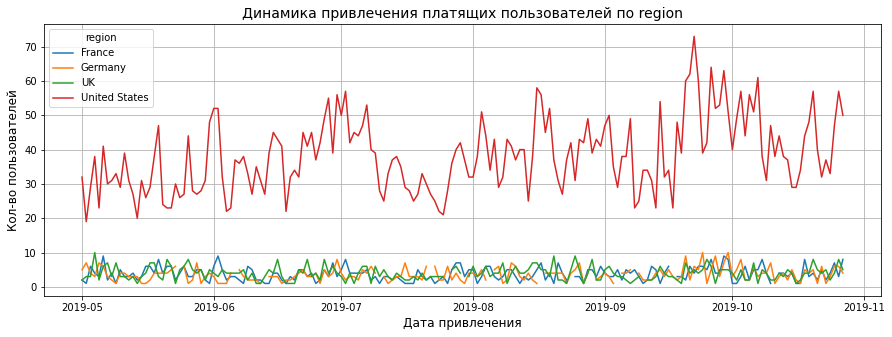

In [24]:
profiles_plot('region')

На данном графике ярко выраженная динамика у ***United States***. Это может говорить о более высоком привлечении средств в рекламу.

Строим таблицу привлечения пользователей по девайсам.

In [25]:
table_conv('device')

,device,total_users,payer_users,users_conv
0,Mac,30042,1912,0.064
1,iPhone,54479,3382,0.062
2,Android,35032,2050,0.059
3,PC,30455,1537,0.050


Пользователи заходят с таких устройств:

- Mac
- iPhone
- Android
- PC

Конверсия выше у устройства ***Mac*** и ***IPhone***, самая низкая конверсия у ***PC***. Заметим что с ***IPhone***  в приложение новые пользователи заходят чаще.

Строим график динамики привлечения платящих пользователей по девайсам.

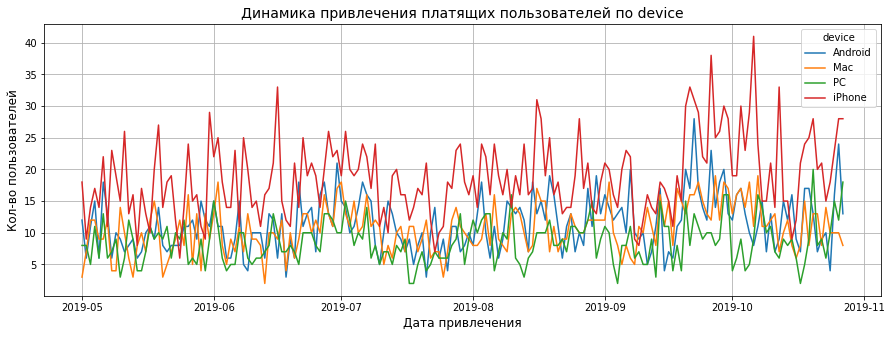

In [26]:
profiles_plot('device')

На графике видны ярко выраженные пики у ***IPhone***, с этого устройства новые платящие пользователи так же заходят чаще. У остальных устройств относительно равномерная динамика. 

Строим таблицу привлечения пользователей по каналам привлечения.

In [27]:
table_conv('channel')

,channel,total_users,payer_users,users_conv
0,FaceBoom,29144,3557,0.122
1,AdNonSense,3880,440,0.113
2,lambdaMediaAds,2149,225,0.105
3,TipTop,19561,1878,0.096
4,RocketSuperAds,4448,352,0.079
5,WahooNetBanner,8553,453,0.053
6,YRabbit,4312,165,0.038
7,MediaTornado,4364,156,0.036
8,LeapBob,8553,262,0.031
9,OppleCreativeMedia,8605,233,0.027


Новые пользователи приходят с таких каналов:

- FaceBoom
- AdNonSense
- lambdaMediaAds
- TipTop
- RocketSuperAds
- WahooNetBanner
- YRabbit
- MediaTornado
- LeapBob
- OppleCreativeMedia
- organic

Самая высокая конверсия у канала **FaceBoom**, чуть более 12%. Привлеченных пользователей больше всего через канал **organic**, конверсия слабая, но сам по себе этот канал привлечения есть и приносит прибыль, это хорошо. У каналов **AdNonSense** и **lambdaMediaAds** хорошая конверсия, но слабая привлекаемость пользователей, возможно из-за низкого бюджета. Стоить обратить на них внимание. **TipTop** тоже привлекает достаточно пользователей и имеет неплохую конверсию. Выводы делать рано, нужно взглянуть на окупаемость.

Строим график динамики привлечения платящих пользователей по каналам привлечения.

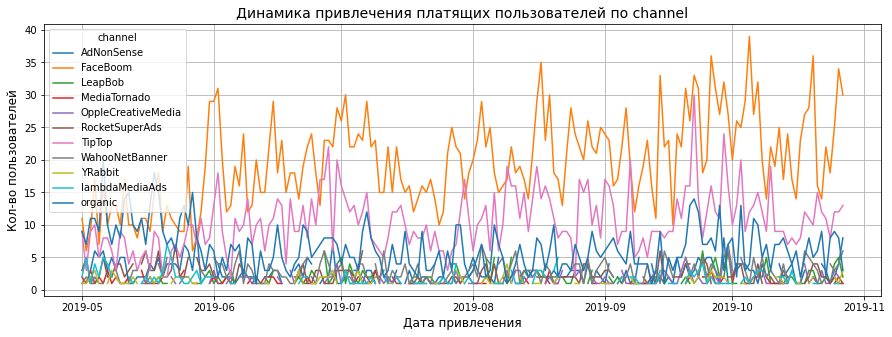

In [28]:
profiles_plot('channel')

***FaceBoom, TipTop и organic*** привлекают больше платящих пользователей чем другие каналы за то же время но динамика привлечения очень яркая. Нам нужен стабильный хороший результат с наименьшими затратами.

***вывод***

Мы выяснили следующее:

Новые пользователи приходят из таких стран:

- France
- Germany
- UK
- United States

Страна ***United States*** привлекает на много больше новых пользователей чем другие страны, конверсия новых пользователей в платящие так же высокая. Остальные страны имеют схожие результаты.

Пользователи заходят с таких устройств:

- Mac
- iPhone
- Android
- PC

Конверсия выше у устройства ***Mac***. Устройством ***IPhone*** пользуются чаще всего, самая низкая конверсия у ***PC*** (Обратим внимание при окупаемости). 

Новые пользователи приходят с таких каналов:

- FaceBoom
- AdNonSense
- lambdaMediaAds
- TipTop
- RocketSuperAds
- WahooNetBanner
- YRabbit
- MediaTornado
- LeapBob
- OppleCreativeMedia
- organic

По каналам у ***FaceBoom*** хорошие показатели по конверсии и привлекаемости новых пользователей. У канала ***TipTop*** хоть и 4 место по конверсии, но по привлекаемости новых платящих пользователей у него второе место. Канал organic за наш период занимает 3 место по привлеченным платящим пользователям, не смотря на низкую конверсию это отличный показатель. **Стоит обратить внимание** на каналы ***AdNonSense*** и ***lambdaMediaAds***, у них хорошая конверсия, но низкая привлекаемсть новых пользователей.

# Шаг 4. Маркетинг

Смотрим сколько всего потрачено на рекламу.

In [29]:
costs['costs'].sum().round()

105497.0

Смотрим на затраты по источникам.

In [30]:
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Очень много средств вложено в канал ***TipTop*** и ***FaceBoom***, на остальные каналы расходов совсем мало. Не удивительно что эти каналы приносят больше платящих пользователей, но окупаются ли эти затраты? Посмотрим на динамику затрат.

Строим график динамики затрат на маркетинг по времени.

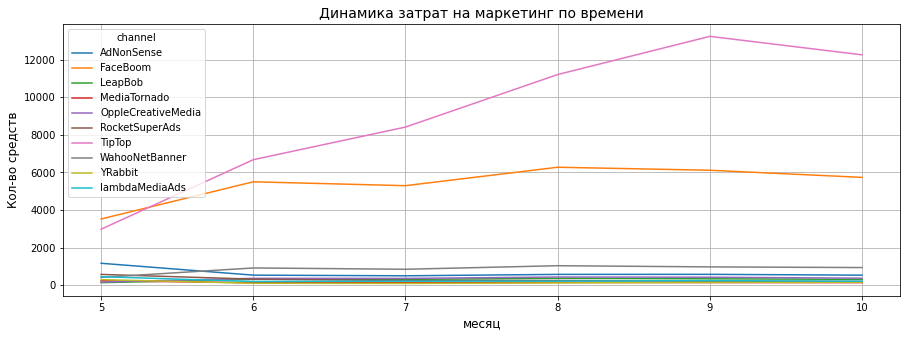

In [31]:
costs_pay = costs.pivot_table(index='channel',columns='dt', values='costs', aggfunc='sum').T.reset_index()
costs_pay['dt'] = pd.to_datetime(costs_pay['dt']).dt.month
costs_pay.groupby('dt').sum().plot(grid=True, figsize=(15,5))
plt.title('Динамика затрат на маркетинг по времени', fontsize=14)
plt.xlabel('месяц', fontsize=12)
plt.ylabel('Кол-во средств', fontsize=12)
plt.show()

Судя по затратам довольно сильно их поднимали на канал ***TipTop*** и по конверсии мы знаем что это не было хорошим решением так как есть рекламные каналы с лучшей конверсией. На ***FaceBoom*** затраты в целом были стабильны. 

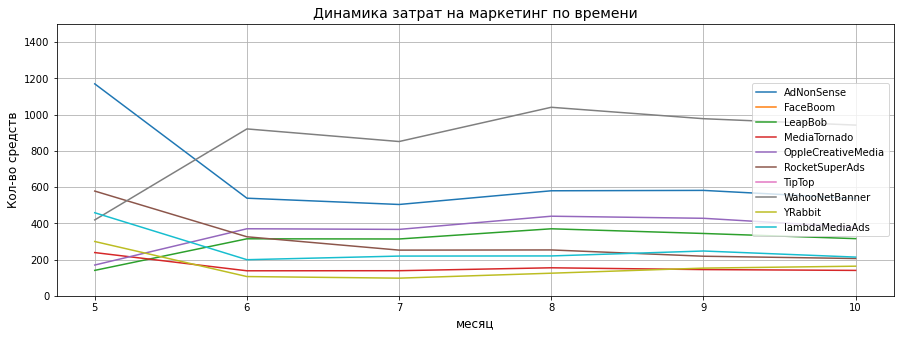

In [32]:
costs_pay.groupby('dt').sum().plot(grid=True, figsize=(15,5))
plt.ylim(0, 1500)
plt.legend(loc='right')
plt.title('Динамика затрат на маркетинг по времени', fontsize=14)
plt.xlabel('месяц', fontsize=12)
plt.ylabel('Кол-во средств', fontsize=12)
plt.show()

На этом графике мы видим снижение бюджета на ***AdNonSense*** в 2 раза и увеличение на канал ***WahooNetBanner*** более чем в 2 раза за наш период. Так же в 2 раза повысили бюджет ***LeapBob*** и ***OppleCreativeMedia***, на остальные каналы бюджет уменьшили.	

Посмотрим на CAC.

Исключим канал ***organic*** из анализа так как это искусственный канал не имеющий затрат и он может повлиять на общую картину исследования.

In [33]:
profiles = profiles.query('channel != "organic"')

Смотрим сколько в среднем стоило привлечение одного пользователя для всего проекта.

In [34]:
profiles['acquisition_cost'].mean()

1.127481323942928

Смотрим сколько в среднем стоило привлечение одного пользователя для каждого источника.

In [35]:
profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)

channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
Name: acquisition_cost, dtype: float64

Канал ***TipTop*** превышает среднюю стоимость затрат более чем в 2 раза. Среди этих результатов нужно искать каналы с хорошей окупаемостью, конверсией пользователей в покупатели и низкой стоимостью привлечения пользователей. Первые три канала в списке довольно сильно отличаются от остальных и они самые дорогостоящие.

Посмотрим на динамику средней стоимости привлечения пользователя по каналам.

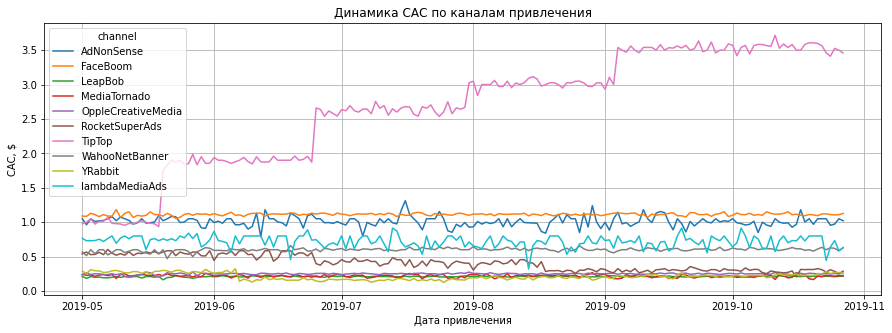

In [36]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

По графику видно что в конце каждого месяца повышались затраты на канал ***TipTop*** за исключением последнего меяца. Нужно проверить окупаемость этих затрат. Так же посмотрим на окупаемость ***FaceBoom*** так как этот канал второй по количеству вложенного рекламного бюджета.

**вывод**

Чуть ***более 80% рекламного бюджета*** тратится на рекламные каналы ***FaceBoom*** и ***TipTop***, причем в ***TipTop*** с каждым месяцем вкладывали всё больше и больше в связи с ростом стоимости привлечения нового покупателя. Так как компания терпит убытки можно сделать вывод что такие вложения рекламного бюджета нерациональны. Проверим на сколько все плохо и найдем рациональное решение.

# Шаг 5. Окупаемость рекламы для привлечения пользователей

In [37]:
observation_date = datetime(2020, 10, 13).date()  
horizon_days = 14 

Общая окупаемость рекламы

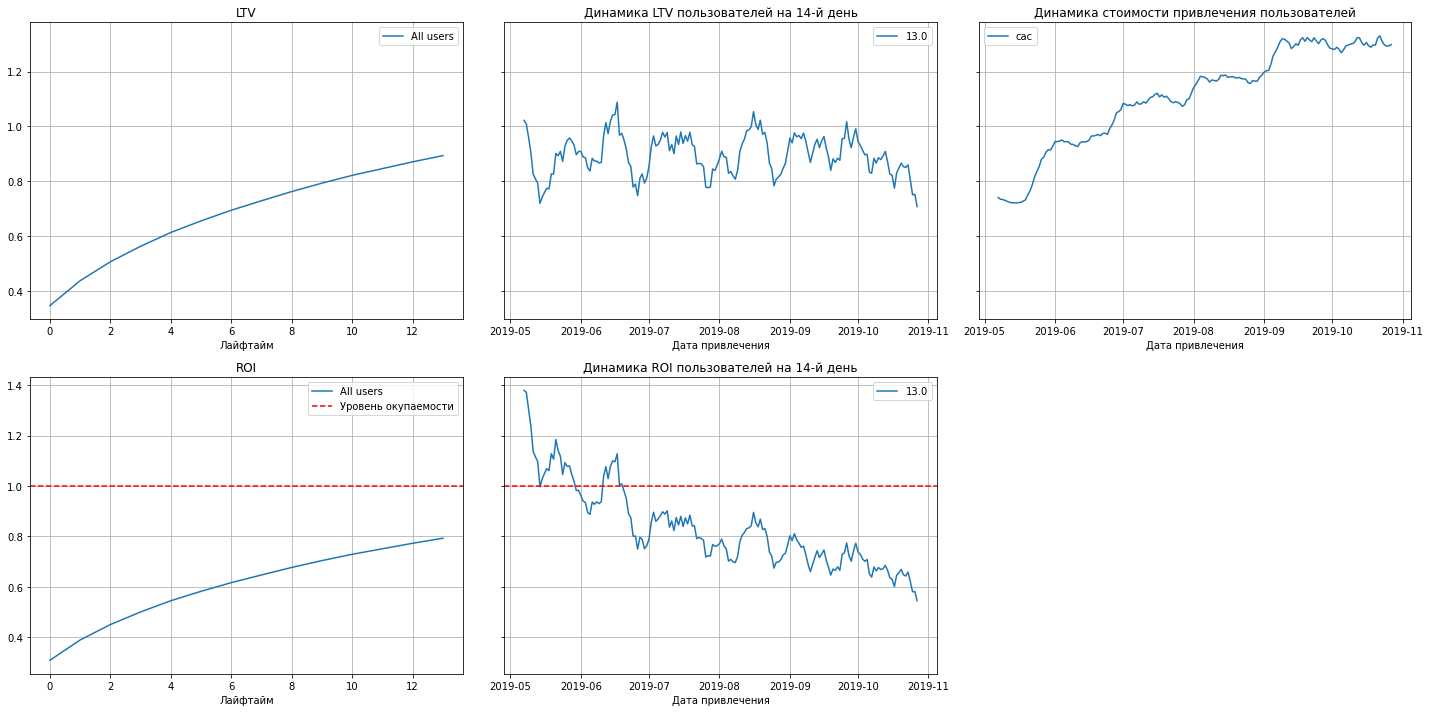

In [38]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:

- Реклама в целом не окупается. *ROI* в конце двух недель составляет 80%.
- *CAC* сильно вырос и график схож с графиком *CAC* канала ***TipTop***. Цена привлечения пользователя росла с каждым месяцем оказывая плохое влияние на *ROI*. 
- На *LTV* влияет сезонный фактор, но и этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

Окупаемость рекламы с разбивкой по устройствам

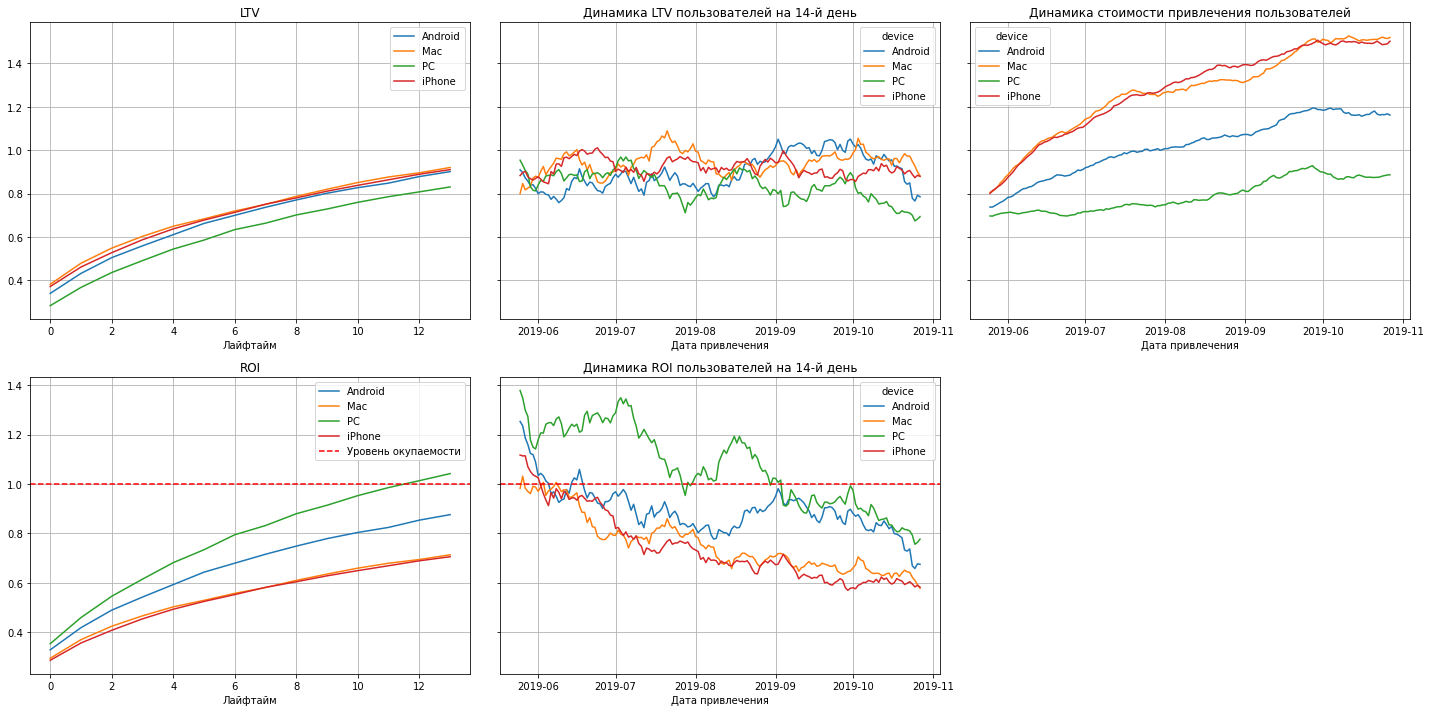

In [39]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days,dimensions=['device']
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days,window=25)

По графикам можно сделать такие выводы:

- Реклама на девайсах *PC* окупается к 12 лайфтайму, остальные девайсы не окупаются. 
- *CAC* рос постепенно на всех девайсах.
- *LTV* медленно снижается предвещая ухудшение ситуации в будущем. Динамика *ROI* показывает что окупаемость *PC* имеет нестабильную динамику и также может перестать окупаться в будущем 

Похоже проблема в стоимости привлечения пользователей. В будущем можно проанализировать почему *PC* и *Android* окупаются по разному. Возможно проблема в оптимизации рикламы под определенный девайс или платформу.

Окупаемость рекламы с разбивкой по странам

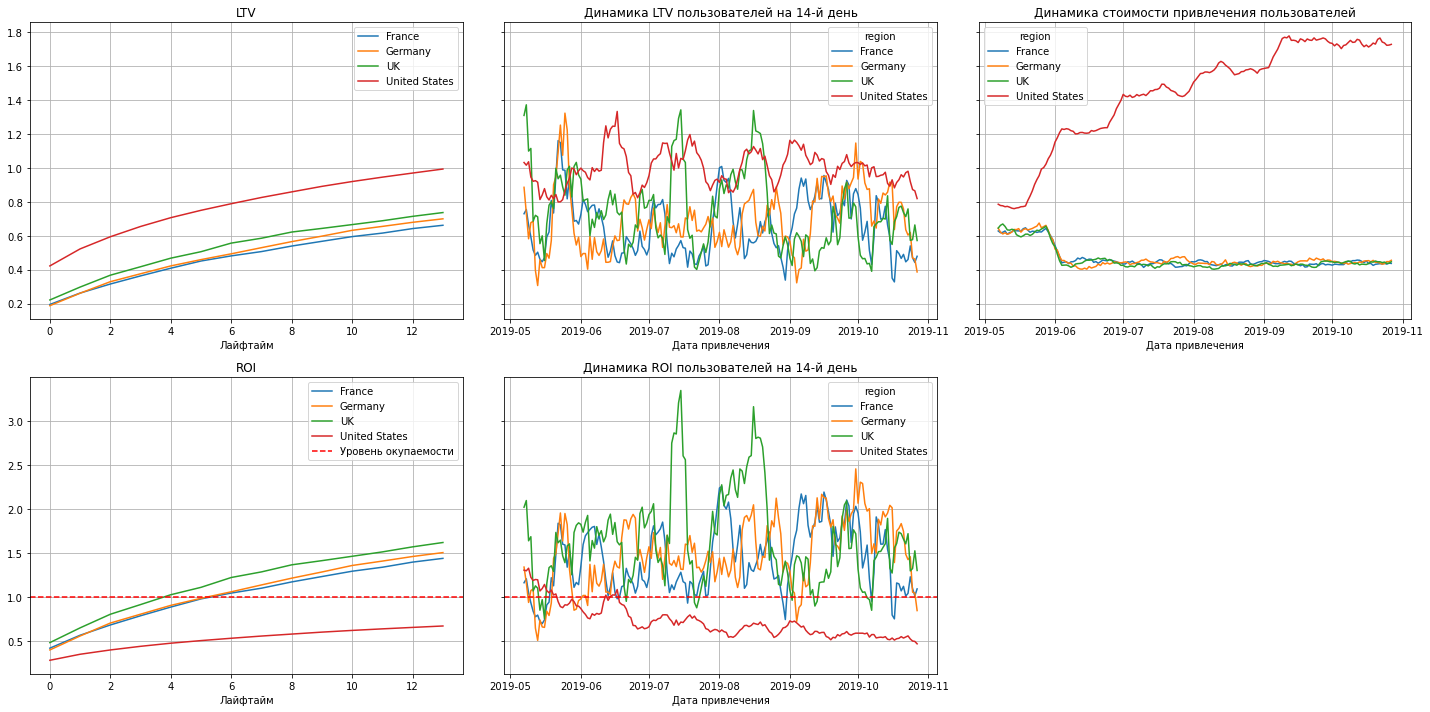

In [40]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days,dimensions=['region']
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

- ***United States*** не окупается и стоимость привлечения пользователей выросла в несколько раз
- В ***UK*** окупаемость наступает на 4 лайфтайме и окупается лучше всего, ***Germany*** и ***France*** на 5 лайфтайме
- *CAC* у всех стран кроме ***United States*** в июне уменьшился
- График *CAC* имеет схожую динамику с графиком *CAC* канала ***TipTop***, можно сделать вывод что этот рекламный канал сильно повлиял на окупаемость в ***United States***

Окупаемость рекламы с разбивкой по рекламным каналам

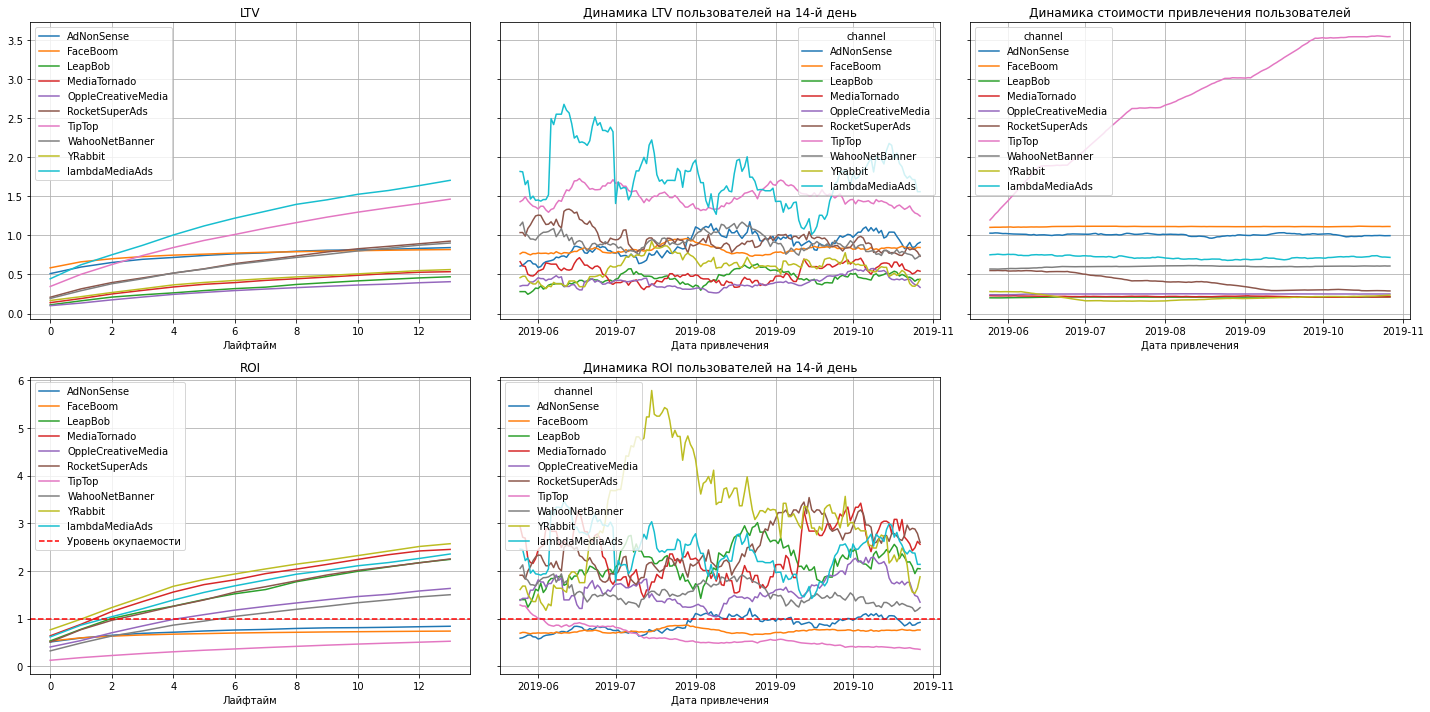

In [41]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days,dimensions=['channel']
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days,window=25)

- По показателям *ROI* видим что каналы ***FaceBoom, TipTop и AdNonSense*** не окупаются
- На 4 и 5 лайфтайме окупаются ***OppleCreativeMedia*** и ***WahooNetBanner***
- Лидер по окупаемости вложений ***YRabbit***, каналы ***MediaTornado***, ***lambdaMediaAds***, ***RocketSuperAds***, ***LeapBob*** тоже хорошо окупаются и имеют хорошую репутацию.
- Канал ***TipTop*** хорошо удерживает пользователей, но из-за стоимости привлечения не окупается.

***вывод***

На данном этапе можно с точностью сказать что рекламный бюджет вкладывается в очень дорогостоящие компании и сильно не окупается по этой причине. Проблемная страна ***United States***. По устройствам не смотря на окупаемость ***PC*** результаты неудовлетворительные, возможно причина в оптимизации рекламы на определенных девайсах или техническая ошибка. Как минимум от рекламных каналов ***TipTop***, ***FaceBoom*** и ***AdNonSense*** нужно отказаться.

Постройте и изучите графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

Ответьте на такие вопросы:

Окупается ли реклама в целом?
Какие устройства, страны и каналы могут снижать окупаемость рекламы?
Чем могут быть вызваны проблемы окупаемости?

Опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

Посмотрим на конверсию и удержание для рекомендаций по привлечению рекламного бюджета.

Упростим построение графиков с помощью функции.

In [42]:
def ret_conv_plot(column,window=7):
    conversion_raw, conversion, conversion_history = get_conversion(
        profiles, orders, observation_date, horizon_days, dimensions=[column]
    )

    plot_conversion(conversion, conversion_history, horizon_days, window=window)

    retention_raw, retention, retention_history = get_retention(
        profiles, visits, observation_date, horizon_days, dimensions=[column]
    )

    plot_retention(retention, retention_history, horizon_days, window=window)
    return

Строим графики конверсии и удержания с разбивкой по странам.

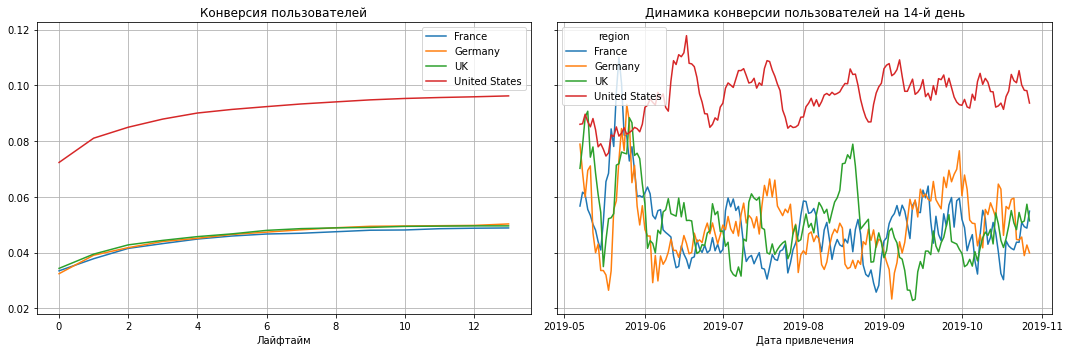

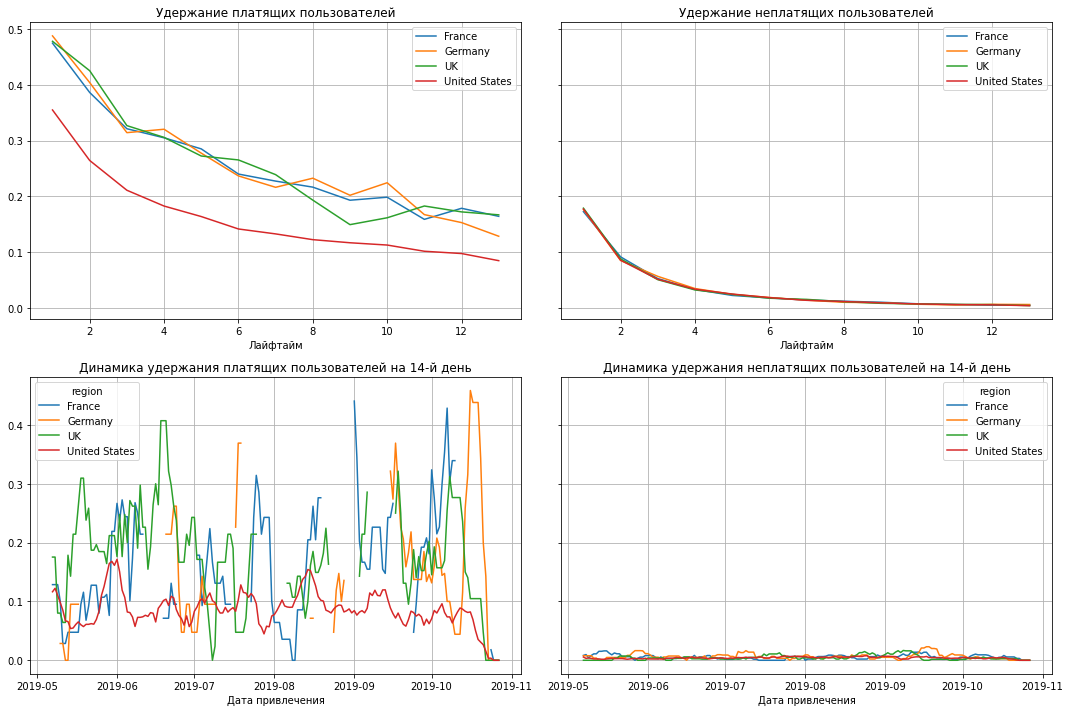

In [43]:
ret_conv_plot('region')

- Не смотря на высокую конверсию ***United States*** удержание платящих пользователей хуже, чем в других странах и снизилась почти до нуля. В других странах удержание выглядит лучше, но не хорошо.
- Динамика удержания неплатящих пользователей схожа во всех странах и также стремительно близится к нулю как в течение двух недель, так и за весь исследуемый период.

Строим графики конверсии и удержания с разбивкой по устройствам.

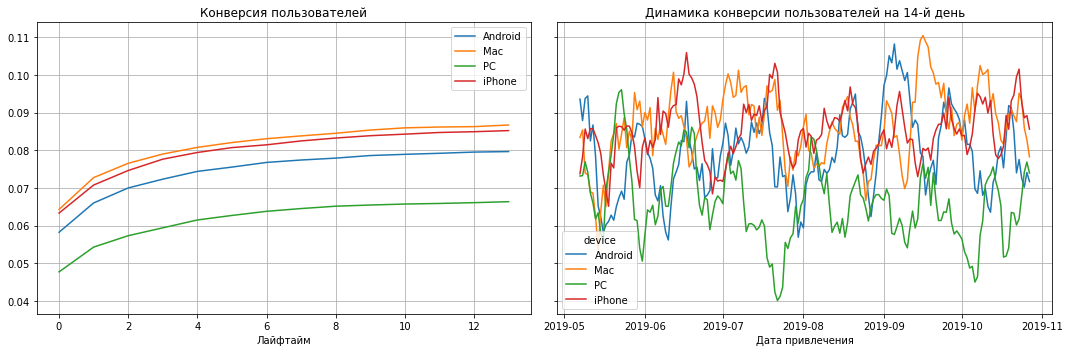

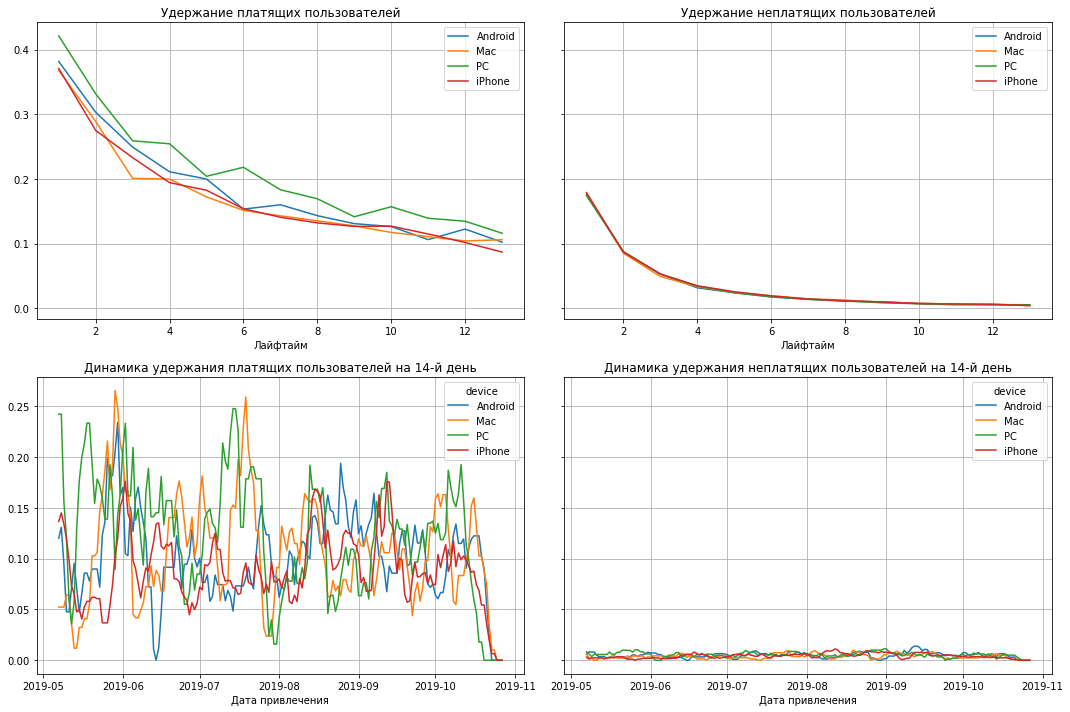

In [44]:
ret_conv_plot('device')

- *CR* на всех устройствах растет, но хуже всех динамика у ***PC***
- *RR* показывает плохие результаты и к дате исследования упал до нуля

Строим графики конверсии и удержания с разбивкой по рекламным каналам.

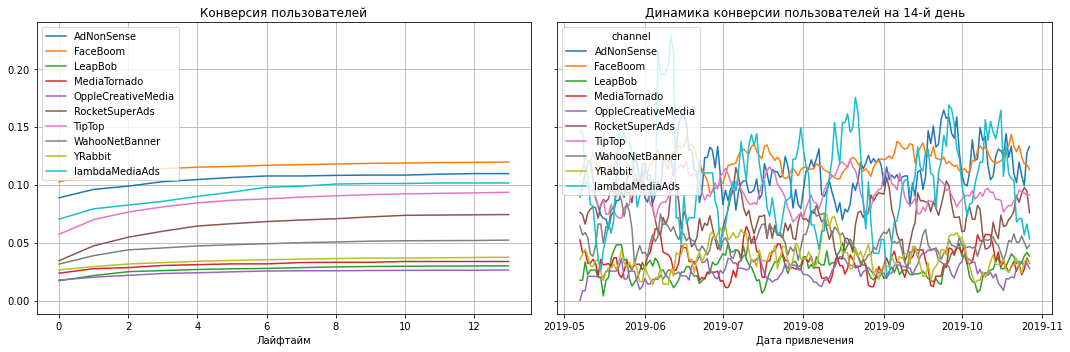

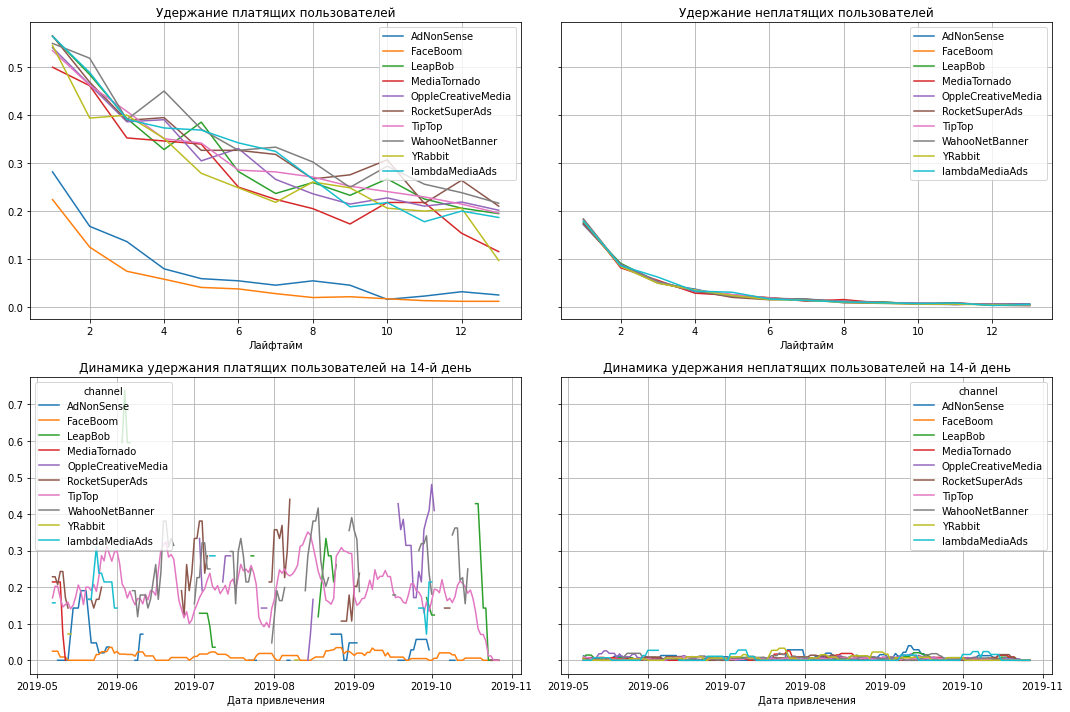

In [45]:
ret_conv_plot('channel')

- *CR* и *RR* имеет хорошие показатели у каналов ***FaceBoom***, ***AdNonSense***, ***TipTop*** и ***lambdaMediaAds***
- У ***RocketSuperAds*** тоже неплохой потенциал, но не лучше чем у лидеров
- Канал ***TipTop*** хорошо удерживает пользователей, но стоимость привлечения слишком высокая
- ***FaceBoom*** и ***AdNonSense*** совсем плохо удерживают пользователей

***вывод***

Проблемы окупаемости в стране ***United States***, на всех устройствах есть проблема.***PC*** окупается но имеет плохие прогнозы. CAC превышает ROI на основных рекламных компаниях, проблема канала ***TipTop*** в высокой цене привлечения при хорошем *RR* и *CR*, каналы ***FaceBoom*** и ***AdNonSense*** так же дороги в привлечении пользователей, но так же при хороших показателях *CR* показатель *RR* у них неудовлетворительный. Выход из ситуации это каналы с высокой *CR*,*RR*,*LTV*,*ROI* и низким *CAC*. Самый лучший кандидат по таким показателям компания ***lambdaMediaAds***, у нее не самый низкий *CAC*, но по остальным показателям результаты хорошие. предлагаю рассмотреть так же ***YRabbit*** (очень низкий *CAC* и не смотря на слабый *LTV* отличный *ROI*), в перспективе можно предложить и каналы ***RocketSuperAds***, ***WahooNetBanner***, ***LeapBob***. Они тоже окупаются и имеют хорошие показатели.

# Шаг 6. Выводы и рекомендации

**В ходе исследовательского анализа мы выяснили**

Проблемная страна: ***United States***

Проблемные рекламные каналы: ***FaceBoom***, ***TipTop***, ***AdNonSense*** 

**Главной причиной убытков были низкие вложения в перспективные рекламные каналы и направление бюджета в каналы, которые не окупаются.** 

Рекомендации:

- Отказаться от рекламного канала ***TipTop*** в связи с высокой стоимостью привлечения пользователей
- Отказаться от рекламного канала ***FaceBoom*** и ***AdNonSense*** в связи с низкой эффективностью рекламы и высокой стоимостью привлечения пользователей.

- **Направить основной рекламный бюджет** в канал ***lambdaMediaAds*** так как он хорошо окупается и у него умеренная цена привлечения пользователей (конверсия 10,5%, окупается уже на 3 день, стоимость привлеченя 0.7)

Потенциальные **компании для дополнительного вложения** рекламного бюджета: 

- ***YRabbit*** (конверсия 3,8%, окупается на 1 день, стоимость привлечения 0.2)
- ***LeapBob*** (конверсия 3,1%, окупается на 2 день, стоимость привлечения 0.2)
- ***RocketSuperAds*** (конверсия 7,9%, окупается на 2 день, стоимость привлечения 0.4)
